# Modelo final ponderado

Para generar un sólo recomendador, se propone ponderar los 3 sistemas generados en uno sólo. Para esto, el modelo final genera recomendaciones con cada uno de los 3 tipos de modelos y luego mezcla estas recomendaciones eligiendo aleatoreamente según ciertas probabilidades asociadas a cada modelo. 

Adicionalmente, se crea la función "Feedback" que actualiza las probabilidades asociadas a cada recomendador para ajustarse más a las preferencias del usuario. De esta manera, si al usuario le gustan más las recomendaciones de un cierto modelo de recomendación, aumentará la probabilidad de que se elijan recomendaciones de ese modelo.

In [1]:
import pandas as pd
import numpy as np

from recommenders import validar_lista, validar_recomendador, Recommender1, Recommender2, Recommender3, RecommenderMean

Se carga y pre procesa los datos

In [2]:
playlists_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_playlists_validation.csv')
tracks_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_tracks_validation.csv')
artist_info = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/artist/2000_artist_sample.csv.gz')

# Se genera set de pids (playlist id) únicos
pids = list(set(playlists_val["pid"]))

cols=tracks_val.columns
tracks_val.columns=[col[15:] if col[:15]=="audio_features." else col for col in cols]
tracks_val = tracks_val.drop(columns=["Unnamed: 0"])

var_names=["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
tracks_info = playlists_val.drop_duplicates(subset=["track_uri"]).set_index("track_uri")[["track_name", "artist_name"]].loc[tracks_val["uri"]]

Se crean las 3 instancias para cada modelo

In [3]:
# Recommender1
avg_features_by_pid = \
        playlists_val \
            .merge(tracks_val, left_on='track_uri', right_on='uri', how='inner') \
            [['pid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] \
            .groupby('pid') \
            .mean() \
            .reset_index()

features_by_pid_plus_artist = \
    playlists_val \
    .merge(tracks_val, left_on='track_uri', right_on='uri', how='inner') \
    [['pid','artist_uri', 'track_uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] \
    .drop_duplicates(subset=['artist_uri']) \
    .merge(artist_info[['artists.uri', 'artists.popularity']], left_on='artist_uri', right_on='artists.uri', how='left') \
    .drop(['artists.uri'], axis=1)

recomendador_1 = Recommender1(avg_features_by_pid)
recomendador_1.fit(avg_features_by_pid.iloc[:, 1:].to_numpy(), 
                   avg_features_by_pid.iloc[:, 0].to_numpy(),
                   features_by_pid_plus_artist)

# Recommender2
recomendador_2=Recommender2(var_names)
recomendador_2.train(tracks_val, playlists_val)

# Recommender3
recomendador_3 = Recommender3(var_names)
recomendador_3.load_data(tracks_val)

0
10
20
30
40


Cargamos una lista de prueba para ver las recomendaciones del modelo ponderado

In [4]:
test=pd.read_csv("10_canciones_features_azar.csv")

FileNotFoundError: [Errno 2] No such file or directory: '10_canciones_features_azar.csv'

Creamos el modelo ponderado dandoles los 3 modelos recomendadores creados anteriormente. Utilizaremos los porcentajes de eficiencia obtenidos en validación para obtener los pesos iniciales asociados a los modelos. De esta manera, el recomendador ponderado inicialmente tendrá más probabilidades de elegir recomendaciones de los modelos que mayor puntaje tuvieron en validación. Con el paso del tiempo, estos puntajes podrían cambiar si el usuario tiene más preferencia por las recomendaciones de un mismo recomendador.

In [385]:
np.random.seed(1991)
rec_promedio=RecommenderMean([recomendador_1, recomendador_2, recomendador_3], [3, 16, 15 ])
tracks_info.loc[rec_promedio.recommend_list(test, number=20)]

,track_name,artist_name
track_uri,,
spotify:track:0J6mQxEZnlRt9ymzFntA6z,Livin' On A Prayer,Bon Jovi
spotify:track:5CjwXdq5Z73Va0XCPFG5Aq,The Good Life,Weezer
spotify:track:29BmtsadNYhlWDKpqyAnVr,Why God Made Love Songs - Single Version,Joel Crouse
spotify:track:7pEjMcUwSQ8E6dzi3AiWHu,Hard to Be Cool,Joe Nichols
spotify:track:0LN0ASTtcGIbNTnjSHG6eO,Pour Some Sugar On Me (2012),Def Leppard
spotify:track:23B2mTKFIHLE9qoLGMMtYW,Born Again Tomorrow,Bon Jovi
spotify:track:3EY7mzKglmxJw21WGUYPLB,Sister Jack,Spoon
spotify:track:756CJtQRFSxEx9jV4P9hpA,I Believe In A Thing Called Love,The Darkness
spotify:track:71DDK14XVxkXLmG3AVi1BP,Storm Warning,Hunter Hayes


Vemos que, en promedio, la eficiencia del recomendador ponderado es un punto intermedio entre las eficiencias de cada recomendador por separado.

Generando recomendaciones Playlist 5 de 50. % Recomendaciones correctas: 69.27
Generando recomendaciones Playlist 10 de 50. % Recomendaciones correctas: 5.15
Generando recomendaciones Playlist 15 de 50. % Recomendaciones correctas: 23.92
Generando recomendaciones Playlist 20 de 50. % Recomendaciones correctas: 16.83
Generando recomendaciones Playlist 25 de 50. % Recomendaciones correctas: 2.38
Generando recomendaciones Playlist 30 de 50. % Recomendaciones correctas: 4.21
Generando recomendaciones Playlist 35 de 50. % Recomendaciones correctas: 1.75
Generando recomendaciones Playlist 40 de 50. % Recomendaciones correctas: 13.16
Generando recomendaciones Playlist 45 de 50. % Recomendaciones correctas: 5.18
Generando recomendaciones Playlist 50 de 50. % Recomendaciones correctas: 12.21
Eficiencia recomendador 3: 12.327250511039415 %


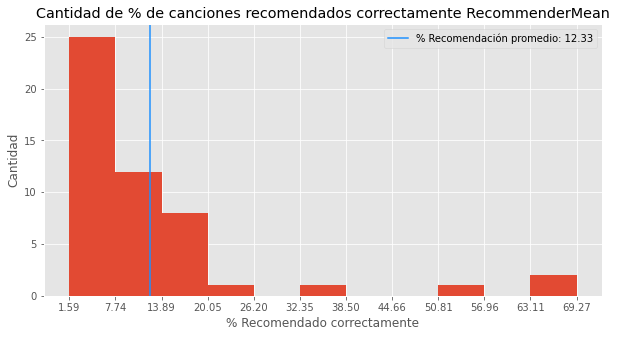

In [392]:
np.random.seed(1991)
eficiencia_pond = validar_recomendador(playlists_val, tracks_val, rec_promedio)
print("Eficiencia recomendador 3:", eficiencia_pond,"%")

### Bonus track

Para implementar el algoritmo de actualización de pesos ponderados, se exploraron algoritmos donde, de no haber sesgo, las probabilidades se mantuvieran relativamente constantes.

En el algoritmo implementado, la esperanza del vector de probabilidades en cada iteración es si misma, dado que no hay sesgo. En otras palabras, cada probabilidad en promedio tiende a mantenerse igual en cada iteración, independiente de la magnitud de la probabilidad. De esta forma, no se ven beneficiados los modelos que en un inicio tienen más probabilidades de ser elegidos.

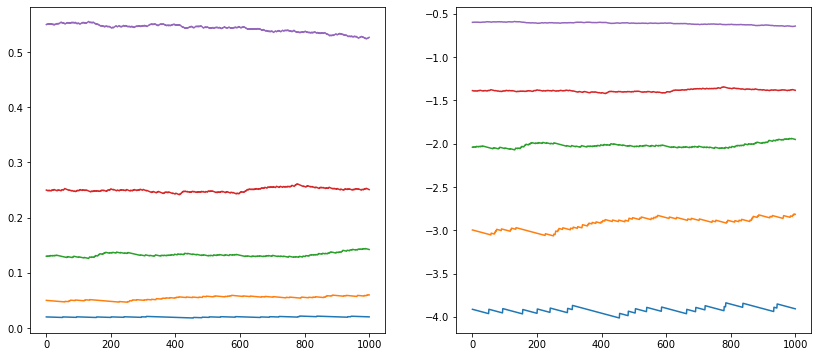

In [3]:
probs_ori=np.asarray([0.02, 0.05, 0.13, 0.25, 0.55])
probs=np.asarray([0.02, 0.05, 0.13, 0.25, 0.55])

all_probs=np.asarray([probs])
for i in range(1000):
    choice=np.zeros(probs.shape)
    choice[np.random.choice(range(len(probs)), p=probs)]=1
    probs=probs*0.999+choice*0.001
    all_probs=np.concatenate((all_probs, probs.reshape(1, -1)))

fig, axes= plt.subplots(1,2, figsize=(14,6))
axes[0].plot(all_probs)
axes[1].plot(np.log(all_probs))

pass